In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import statsmodels
from scipy.stats import normaltest
from scipy.stats import shapiro
from scipy.stats import ttest_ind

In [2]:
test = pd.read_csv('tests_HW.zip')
test.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


        Компании заинтересованы в ответах на два вопроса:

Будет ли кампания успешной?


Если кампания была успешной, насколько этот успех можно объяснить рекламой?

    Идея задания состоит в том, чтобы проанализировать группы, выяснить, была ли реклама успешной, сколько компания может заработать на рекламе и является ли разница между группами статистически значимой.

user id: Идентификатор пользователя (уникальный).

test group: Если "ad", то человек видел рекламу, если "psa", то он видел только объявление государственной службы.

converted: Если человек купил продукт, то True, иначе False.

total ads: Количество рекламы, увиденной человеком.

most ads day: День, в который человек увидел наибольшее количество рекламы.

most ads hour: Час дня, в который человек увидел наибольшее количество рекламы.


In [3]:
test.info()
# Пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


Работа со столбцами:

1. test_group - можем привести к категориальным 

2. most_ads_day - приводим к категориальным

3. most_ads_hour - приводим к категориальным
    


In [4]:
# Делаем копию датасета
df = test.copy()

In [5]:
df['test group'] = df['test group'].astype('category')
df['most ads day'] = df['most ads day'].astype('category')
df['most ads hour'] = df['most ads hour'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Unnamed: 0     588101 non-null  int64   
 1   user id        588101 non-null  int64   
 2   test group     588101 non-null  category
 3   converted      588101 non-null  bool    
 4   total ads      588101 non-null  int64   
 5   most ads day   588101 non-null  category
 6   most ads hour  588101 non-null  category
dtypes: bool(1), category(3), int64(3)
memory usage: 15.7 MB


In [6]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [7]:
df.describe()

,Unnamed: 0,user id,total ads
count,588101.000000,5.881010e+05,588101.000000
mean,294050.000000,1.310692e+06,24.820876
std,169770.279667,2.022260e+05,43.715181
min,0.000000,9.000000e+05,1.000000
25%,147025.000000,1.143190e+06,4.000000
50%,294050.000000,1.313725e+06,13.000000
75%,441075.000000,1.484088e+06,27.000000
max,588100.000000,1.654483e+06,2065.000000


Проверьте данные на наличие пропусков и избавьтесь от них, если нужно.
### Пропусков не обнаружено

In [8]:
# Разделим на A-B группы
df_a = df[df['test group'] =='ad']
df_b = df[df['test group'] =='psa']

Проверьте, есть ли пользователи, которые в процессе A/Bтеста попали в обе группы. Если да, исключите пользователей, оказавшихся в обеих группах.

In [41]:
#Первым методом
df.groupby('user id')['test group'].count().value_counts()
#Нет пользователей попавших в обе группы

test group
1    588101
Name: count, dtype: int64

In [10]:
# Вторым методом
# Пользователи из группы А(ad) и B(psa)
users_ad = df_a['user id']
users_psa = df_b['user id']

# Проверка наличия пересечения пользователей
intersection_users = set(users_ad) & set(users_psa)

if intersection_users:
    # Исключение пользователей, попавших в обе группы
    users_ad = list(set(users_ad) - intersection_users)
    users_psa = list(set(users_psa) - intersection_users)

    # Вывод результатов
    print(f"Исключены пользователи, попавшие в обе группы: {list(intersection_users)}")
    print(f"Обновленный список пользователей в группе ad: {users_ad}")
    print(f"Обновленный список пользователей в группе psa: {users_psa}")
else:
    print("Нет пользователей, попавших в обе группы.")


Нет пользователей, попавших в обе группы.


    Стоит вопрос: убирать выбросы или нет?. 

Ниже по boxplot видим, что данные в группах с большими выбросами, однако выбросов довольно много, удалив их мы все равно не добьемся нормального распределения (и QQplot ниже нам это доказывает), также довольно сложно проконтролировать действительно ли человек просмотрел столько рекламмы или нет

-> поэтому в данной работе я пока не стал убирать выбросы

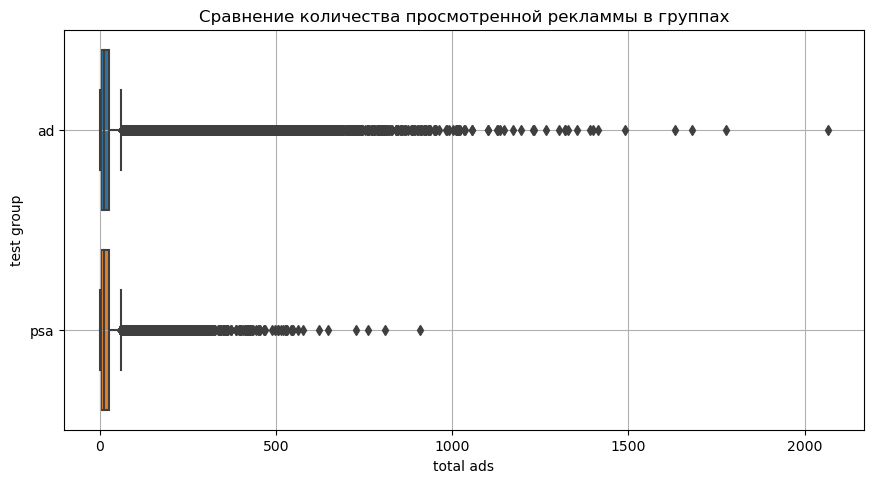

In [11]:
fig = plt.figure(figsize=(8, 4)) 
ax = fig.add_axes([1, 1, 1, 1]) 

# строим boxplot для conversion по признаку group
sns.boxplot(data=df, x='total ads', y='test group', ax=ax) 
ax.set_title('Сравнение количества просмотренной рекламмы в группах')
ax.grid();

In [12]:
def outliers_iqr(data:np.array, feature:pd.Series):
    """
    Функция для выявления выбросов по методу Тьюоки
    с помощью интерквартильного размаха (IQR)
    На вход подается датасе и признак который мы хотим
    проанальизировать.
    Возвращается:
    чисkо выбросов (outliers) и количество конечных записей (cleaned)
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned


Число выбросов по методу Тьюки для группы ad: 49861
Результирующее число записей: 514716
Процент выбросов: 9.7


c:\Users\minik\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8651376962661743, pvalue=0.0)
NormaltestResult(statistic=87296.27292838864, pvalue=0.0)


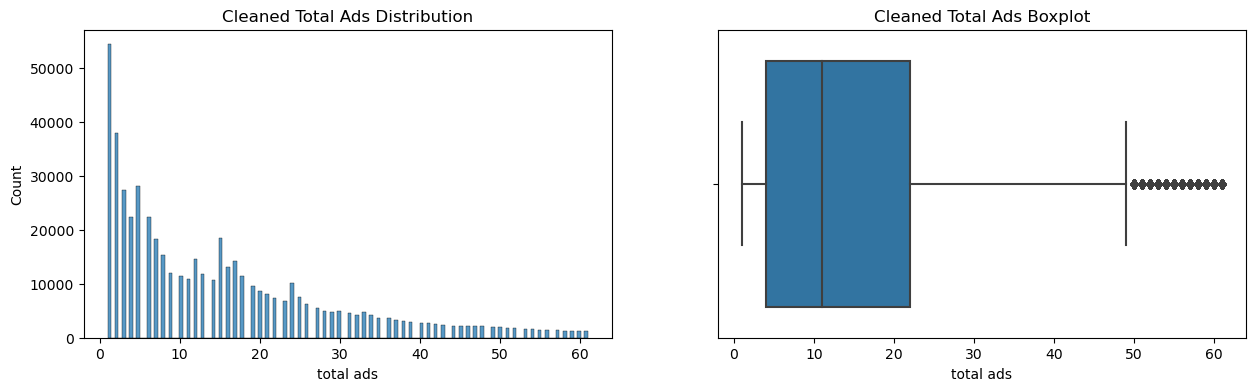

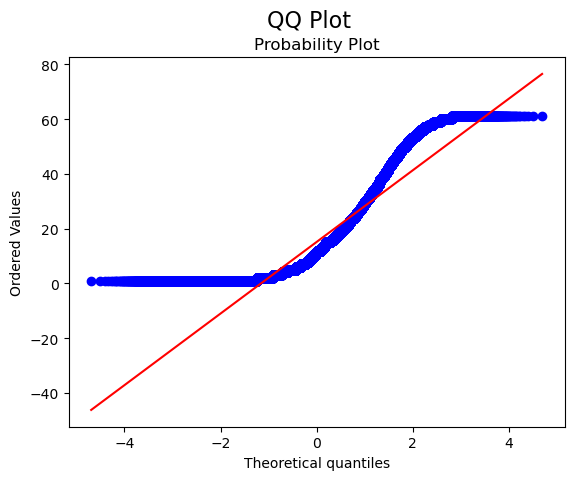

In [13]:
outliers, cleaned = outliers_iqr(df_a, 'total ads')
print(f'Число выбросов по методу Тьюки для группы ad: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Процент выбросов: {round((outliers.shape[0]/cleaned.shape[0])*100,1)}')

#Строим визуализацию после удаления выборосов
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='total ads', ax=axes[0]);
histplot.set_title('Cleaned Total Ads Distribution');
boxplot = sns.boxplot(data=cleaned, x='total ads', ax=axes[1]);
boxplot.set_title('Cleaned Total Ads Boxplot');

# Тест на нормальность графически с помощью QQ-plot
fig, (ax1) = plt.subplots(1)
fig.suptitle('QQ Plot', fontsize=16)
stats.probplot(cleaned['total ads'],dist="norm", plot=ax1)

# Тест на нормальность Шапиро-Уилка
print(shapiro(cleaned['total ads']))
# Тест на нормальность Д'Агостино
print(normaltest(cleaned['total ads']))

Число выбросов по методу Тьюки для группы psa: 2321
Результирующее число записей: 21159
Процент выбросов: 11.0


c:\Users\minik\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8529506921768188, pvalue=0.0)
NormaltestResult(statistic=3590.554395697545, pvalue=0.0)


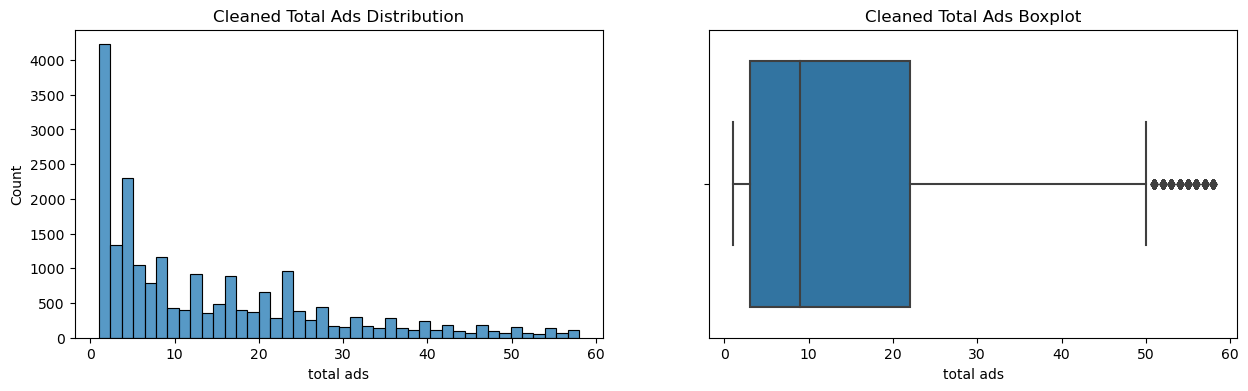

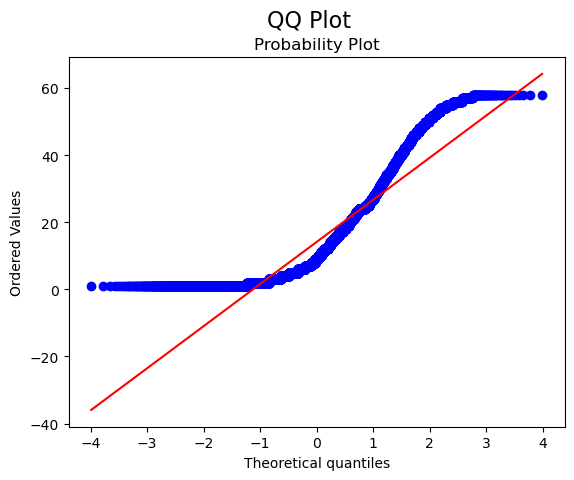

In [14]:
outliers, cleaned = outliers_iqr(df_b, 'total ads')
print(f'Число выбросов по методу Тьюки для группы psa: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Процент выбросов: {round((outliers.shape[0]/cleaned.shape[0])*100,1)}')

#Строим визуализацию после удаления выборосов
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='total ads', ax=axes[0]);
histplot.set_title('Cleaned Total Ads Distribution');
boxplot = sns.boxplot(data=cleaned, x='total ads', ax=axes[1]);
boxplot.set_title('Cleaned Total Ads Boxplot');

# Тест на нормальность графически с помощью QQ-plot
fig, (ax1) = plt.subplots(1)
fig.suptitle('QQ Plot', fontsize=16)
stats.probplot(cleaned['total ads'],dist="norm", plot=ax1)

# Тест на нормальность Шапиро-Уилка
print(shapiro(cleaned['total ads']))
# Тест на нормальность Д'Агостино
print(normaltest(cleaned['total ads']))

            Сделайте первичный анализ результатов A/B-тестирования
Рассчитайте вспомогательные показатели для контрольной и тестовой групп:

In [15]:
# Количество посещений сайта;
# Cуммарное количество совершённых покупок;
count_visit = df.groupby(['test group']).agg({
    'user id': 'count',
    'converted': 'sum'
}).reset_index()
count_visit

,test group,user id,converted
0,ad,564577,14423
1,psa,23524,420


1. Сопоставимо ли количество посещений обоих вариантов посадочной страницы? 

2. Можно ли говорить о сбалансированности выборок?

        Видим, что в группе ad - посещиний гораздо больше. Соотвественно и говорить о сбаласированности выборок нельзя


В каждой из групп рассчитайте ключевые показатели:


In [16]:
# Конверсия группы ad и pas в %
count_visit['conversion'] = (count_visit['converted']*100)/ count_visit['user id']

count_visit.head()

,test group,user id,converted,conversion
0,ad,564577,14423,2.554656
1,psa,23524,420,1.785411


На первый взгляд эффективнее вариант А

In [17]:
mean_ads = df.groupby(['test group']).agg({
    'total ads': 'mean'
}).reset_index()

mean_ads
# Среднее количество рекламмы увиденной пользователями почти 
# одинаково, на ~ 0.06 больше в Ad

,test group,total ads
0,ad,24.823365
1,psa,24.761138


### Сформулируйте статистические гипотезы, соответствующие поставленным бизнес-вопросам;


Проверяем гипотезу по конверсии

    *Не забудьте проверить данные на нормальность там, где это необходимо.



В рамках данных df['converted'] проверять распределение на нормальность не имеет смысла, т.к. переменная бинарная.

    Обычно для бинарных переменных используют метод пропорций

In [18]:
from statsmodels.stats.proportion import proportions_ztest

In [19]:
# Two-sided
H0 = "Нет статистически значимого различия в конверсии между группами ad и psa"
H1 = "Есть статистически значимое различие в конверсии между группами ad и psa" 
alpha = 0.05
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=count_visit['converted'], #число "успехов"
    nobs=count_visit['user id'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 5))

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print(f"Отвергаем нулевую гипотезу : {H0}")
    print(f"Альтернативная гипотеза H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value:  0.0
Отвергаем нулевую гипотезу : Нет статистически значимого различия в конверсии между группами ad и psa
Альтернативная гипотеза H1: Есть статистически значимое различие в конверсии между группами ad и psa


In [20]:
# Larger
H0 = "Нет статистически значимого различия в конверсиях в группах"
H1 = "Конверсия в группе ad больше конверсии в группе psa" 
alpha = 0.05
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=count_visit['converted'], #число "успехов"
    nobs=count_visit['user id'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', p_value)

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print(f"Отвергаем нулевую гипотезу : {H0}")
    print(f"Альтернативная гипотеза H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value:  8.526403580779863e-14
Отвергаем нулевую гипотезу : Нет статистически значимого различия в конверсиях в группах
Альтернативная гипотеза H1: Конверсия в группе ad больше конверсии в группе psa


In [21]:
# Smaller
H0 = "Конверсия в группе ad равна конверсии в группе psa"
H1 = "Конверсия в группе ad меньше конверсии в группе ps" 
alpha = 0.05
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=count_visit['converted'], #число "успехов"
    nobs=count_visit['user id'], #общее число наблюдений
    alternative='smaller',
)
# выводим результат на экран
print('p-value: ', p_value)

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print(f"Отвергаем нулевую гипотезу : {H0}")
    print(f"Альтернативная гипотеза H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value:  0.9999999999999147
Принимаем нулевую гипотезу. Конверсия в группе ad равна конверсии в группе psa


    Делаем вывод: существует статистическая разница между конверсиями в разных группах, конкретно для гипотезы Greater подверждается, что в группе ad статистически конверсия больше

Проверяем гипотезу по среднему количеству просмотренной рекламмы

In [22]:
# Среднее количество просмотренной рекламмы в группах
mean_ads

,test group,total ads
0,ad,24.823365
1,psa,24.761138


Здесь уже необходимо проверить распределение на нормальность

c:\Users\minik\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.4787434935569763, pvalue=0.0)
NormaltestResult(statistic=757442.9548815457, pvalue=0.0)


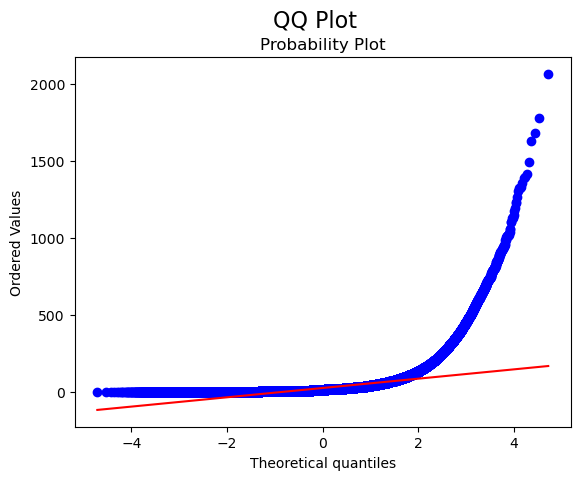

In [23]:
# Тест на нормальность графически с помощью QQ-plot
fig, (ax1) = plt.subplots(1)
fig.suptitle('QQ Plot', fontsize=16)
stats.probplot(df_a['total ads'],dist="norm", plot=ax1)

# Тест на нормальность Шапиро-Уилка
print(shapiro(df_a['total ads']))
# Тест на нормальность Д'Агостино
print(normaltest(df_a['total ads']))

ShapiroResult(statistic=0.5159035921096802, pvalue=0.0)
NormaltestResult(statistic=26073.244160196744, pvalue=0.0)


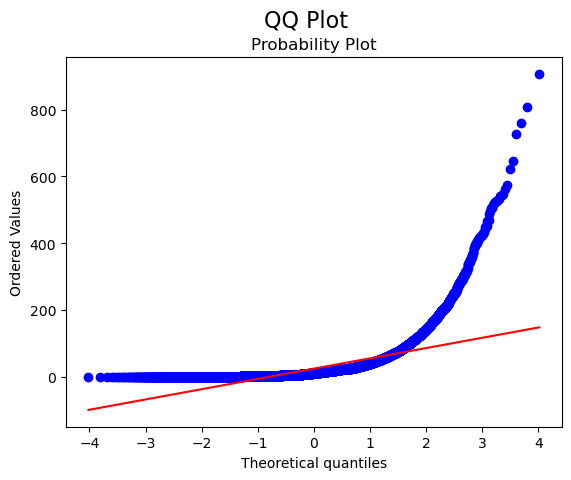

In [24]:
# Тест на нормальность графически с помощью QQ-plot
fig, (ax1) = plt.subplots(1)
fig.suptitle('QQ Plot', fontsize=16)
stats.probplot(df_b['total ads'],dist="norm", plot=ax1)

# Тест на нормальность Шапиро-Уилка
print(shapiro(df_b['total ads']))
# Тест на нормальность Д'Агостино
print(normaltest(df_b['total ads']))

Распределение не нормальное, следовательно воспользоваться параметрическими тестами мы не можем. Под наши критерии подходит статистический тест Манни-Уитни - Вилкоксона (U критерий Манна-Уитни) - непараметрическую альтернативу t-критерия для независимых выборок

In [25]:
from scipy.stats import mannwhitneyu

In [26]:
# Предварительный результат по двусторонней теории
mannwhitneyu(df_a['total ads'], df_b['total ads'], alternative='two-sided')

MannwhitneyuResult(statistic=6808288222.0, pvalue=4.6909108547205694e-11)

In [27]:
#Two-Sided
H0 = "Различия в среднем количестве просмотренной рекламы статистически незначимы"
H1 = "Есть статистически значимые различия в среднем количестве просмотренной рекламы между группами"

group_ad = df_a['total ads']
group_psa = df_b['total ads']

# Проведение U-теста Манна-Уитни
statistic, p_value = mannwhitneyu(group_ad, group_psa, alternative='two-sided')

# Вывод результатов
print(f'Статистика U: {statistic}')
print(f'p-значение: {p_value}')

# Проверка статистической значимости
alpha = 0.05
if p_value < alpha:
    print(f"Отвергаем нулевую гипотезу, придерживаемся альтернативной: {H1}.")
else:
    print(f"Нет оснований отвергнуть нулевую гипотезу: {H0}.")

Статистика U: 6808288222.0
p-значение: 4.6909108547205694e-11
Отвергаем нулевую гипотезу, придерживаемся альтернативной: Есть статистически значимые различия в среднем количестве просмотренной рекламы между группами.


In [28]:
#Greater
H0 = "Среднее количество просмотров в группе ad не больше, чем в группе psa"
H1 = "Среднее количество просмотров в группе ad больше, чем в группе psa"

group_ad = df_a['total ads']
group_psa = df_b['total ads']

# Проведение U-теста Манна-Уитни
statistic, p_value = mannwhitneyu(group_ad, group_psa, alternative='greater')

# Вывод результатов
print(f'Статистика U: {statistic}')
print(f'p-значение: {p_value}')

# Проверка статистической значимости
alpha = 0.05
if p_value < alpha:
    print(f"Отвергаем нулевую гипотезу, придерживаемся альтернативной: {H1}.")
else:
    print(f"Нет оснований отвергнуть нулевую гипотезу: {H0}.")

Статистика U: 6808288222.0
p-значение: 2.3454554273602847e-11
Отвергаем нулевую гипотезу, придерживаемся альтернативной: Среднее количество просмотров в группе ad больше, чем в группе psa.


In [29]:
#Less
H0 = "Среднее количество просмотров в группе ad не больше, чем в группе psa"
H1 = "Среднее количество просмотров в группе ad меньше, чем в группе psa"

group_ad = df_a['total ads']
group_psa = df_b['total ads']

# Проведение U-теста Манна-Уитни
statistic, p_value = mannwhitneyu(group_ad, group_psa, alternative='less')

# Вывод результатов
print(f'Статистика U: {statistic}')
print(f'p-значение: {p_value}')

# Проверка статистической значимости
alpha = 0.05
if p_value < alpha:
    print(f"Отвергаем нулевую гипотезу, придерживаемся альтернативной: {H1}.")
else:
    print(f"Нет оснований отвергнуть нулевую гипотезу: {H0}.")

Статистика U: 6808288222.0
p-значение: 0.9999999999765454
Нет оснований отвергнуть нулевую гипотезу: Среднее количество просмотров в группе ad не больше, чем в группе psa.


    Да, судя по тестам мы точно можем сказать, что среднее количество просмотренной рекламмы в группах не равно.
    
    Судя по тесту Greater не можем отвергнуть гипотезу: Среднее количество просмотров в группе ad больше, чем в группе psa

###  Теперь сравним по доверительным интервалам

Доверительный интервал конверсий в каждой из групп;

In [30]:
count_visit

,test group,user id,converted,conversion
0,ad,564577,14423,2.554656
1,psa,23524,420,1.785411


In [31]:
# Метод 1
from statsmodels.stats.proportion import proportion_confint

# Данные
mask_ad = count_visit['test group'] == 'ad'
mask_psa = count_visit['test group'] == 'psa'

# Доверительный интервал Уилсона для группы ad
success_ad, nobs_ad = count_visit[mask_ad]['converted'], count_visit[mask_ad]['user id']
ci_conv_ad_1 = proportion_confint(success_ad, nobs_ad, method='wilson')

# Доверительный интервал Уилсона для группы psa
success_psa, nobs_psa = count_visit[mask_psa]['converted'], count_visit[mask_psa]['user id']
ci_conv_psa_1 = proportion_confint(success_psa, nobs_psa, method='wilson')

# Вывод результатов
print(f"Доверительный интервал конверсии для группы ad: ({ci_conv_ad_1[0][0]},{ci_conv_ad_1[1][0]})")
print(f"Доверительный интервал конверсии для группы psa: ({ci_conv_psa_1[0][1]}, {ci_conv_psa_1[1][1]})")


Доверительный интервал конверсии для группы ad: (0.02513821650599992,0.025961359215123686)
Доверительный интервал конверсии для группы psa: (0.016238943989596074, 0.019626711612411318)


In [32]:
# Метод 2 через std
# Конверсии нужно перевести в изначальный вид
сonv_ad = count_visit[mask_ad]['conversion']/100
conv_psa = count_visit[mask_psa]['conversion']/100

# Стандартные ошибки
std_ad = np.sqrt((сonv_ad * (1 - сonv_ad)) / nobs_ad)
std_psa = np.sqrt((conv_psa * (1 - conv_psa)) / nobs_psa)

# Z-значение для 95% доверительного интервала
z_value = 1.96

# Доверительные интервалы
ci_conv_ad_2 = (сonv_ad - z_value * std_ad, сonv_ad + z_value * std_ad)
ci_conv_psa_2 = (conv_psa - z_value * std_psa, conv_psa + z_value * std_psa)

# Вывод результатов
print(f"Доверительный интервал конверсии для группы ad: ({ci_conv_ad_2[0][0]}, {ci_conv_ad_2[1][0]})")
print(f"Доверительный интервал конверсии для группы psa: ({ci_conv_psa_2[0][1]}, {ci_conv_psa_2[1][1]})")


Доверительный интервал конверсии для группы ad: (0.02513499198005383, 0.025958127293313666)
Доверительный интервал конверсии для группы psa: (0.01616188362021982, 0.019546329268744642)


Доверительный интервал разницы конверсий в группах;

In [33]:
count_visit['conv'] = count_visit['conversion']/100

In [34]:
count_visit

,test group,user id,converted,conversion,conv
0,ad,564577,14423,2.554656,0.025547
1,psa,23524,420,1.785411,0.017854


In [35]:
# Возьмем данные с таблицы count_visit выше
conv_ad = 0.025547 
conv_psa = 0.017854
nobs_ad = 564577 #общее количество пользователей в группе ad
nobs_psa = 23524 #общее количество пользователей в группе psa

# Разница конверсий
conversion_diff = conv_ad - conv_psa

# Стандартная ошибка разницы
std_diff = ((conv_ad * (1 - conv_ad) / nobs_ad) + (conv_psa * (1 - conv_psa) / nobs_psa))**0.5

# Z-значение для 95% доверительного интервала
z_value = 1.96

# Доверительный интервал разницы конверсий
ci_diff = (conversion_diff - z_value * std_diff, conversion_diff + z_value * std_diff)

# Вывод результатов
print(f"Доверительный интервал разницы конверсий: ({ci_diff[0]}, {ci_diff[1]})")


Доверительный интервал разницы конверсий: (0.0059514512341076724, 0.009434548765892331)


In [36]:
print(f'Разница конверсий в доверительном интервале: {ci_diff[1] - ci_diff[0]}')

Разница конверсий в доверительном интервале: 0.003483097531784659


По доверительным интервалам мы видим, что разница конверсий состовляет всего 0.00348, что можно было бы интерпретировать как отсутствие какой то значиомсти. 

    Строим CI среднего количества увиденной рекламы в группах А и B.
    
    Доверительный интервал по среднему количеству уведенной рекламы в группе А

    Сначала попробуем построить без Bootstrap

In [37]:
import statistics
from scipy.stats import t

n_a = df_a['user id'].count() # размер выборки
k_a = n_a-1 # число степеней свободы
x_mean_a = df_a['total ads'].mean() # выборочное среднее
x_std_a = statistics.stdev(df_a['total ads']) # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
t_crit = -t.ppf(alpha/2, k_a) # t-критическое

eps = t_crit * x_std_a/(n_a ** 0.5) # погрешность
lower_bound = x_mean_a - eps # левая (нижняя) граница
upper_bound = x_mean_a + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print(f'Доверительный интервал среднего количества просмотренной рекламмы по группе ad: {confidence_interval}') # выводим результа

Доверительный интервал среднего количества просмотренной рекламмы по группе ad: (25, 25)


Доверительный интервал по среднему количеству уведенной рекламы в группе В

In [38]:
n_b = df_b['user id'].count() # размер выборки
k_b = n_b-1 # число степеней свободы
x_mean_b = df_b['total ads'].mean() # выборочное среднее
x_std_b = statistics.stdev(df_b['total ads']) # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

eps = t_crit * x_std_b/(n_b ** 0.5) # погрешность
lower_bound = x_mean_b - eps # левая (нижняя) граница
upper_bound = x_mean_b + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print(f'Доверительный интервал: {confidence_interval}') # выводим результа

Доверительный интервал: (24, 25)


    Видим, что интервалы перекрываются.Теперь сделаем по правильному через Bootstrap


Доверительный интервал среднего для группы ad: (24.70186728293926, 24.93937682548173)
Доверительный интервал среднего для группы psa: (24.22804476279544, 25.308022657711273)


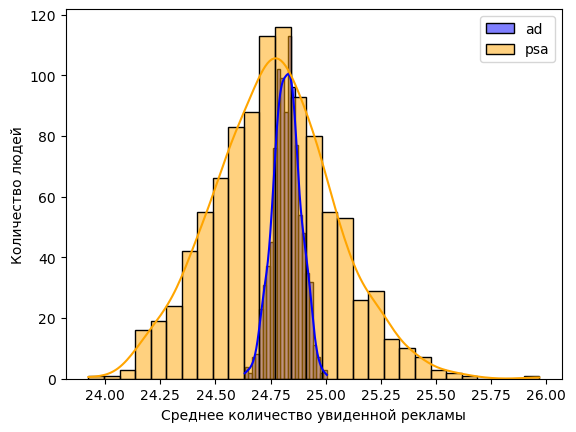

In [39]:
# Метод 1
# Данные
group_ad = df_a['total ads']
group_psa = df_b['total ads']

# Функция для бутстрэп-выборок
def bootstrap_sample(data, num_samples=1000):
    samples = []
    for _ in range(num_samples):
        sample = np.random.choice(data, size=len(data), replace=True)
        samples.append(sample)
    return samples

# Функция для расчета интересующей статистики (например, среднего)
def calculate_statistic(data):
    return np.mean(data)

# Создание бутстрэп-выборок для каждой группы
bootstrap_samples_ad = bootstrap_sample(group_ad)
bootstrap_samples_psa = bootstrap_sample(group_psa)

# Расчет статистики для каждой бутстрэп-выборки
bootstrap_means_ad = [calculate_statistic(sample) for sample in bootstrap_samples_ad]
bootstrap_means_psa = [calculate_statistic(sample) for sample in bootstrap_samples_psa]

# Расчет доверительных интервалов
ci_ads_ad = np.percentile(bootstrap_means_ad, [2.5, 97.5])
ci_ads_psa = np.percentile(bootstrap_means_psa, [2.5, 97.5])

# Вывод результатов
print(f"Доверительный интервал среднего для группы ad: ({ci_ads_ad[0]}, {ci_ads_ad[1]})")
print(f"Доверительный интервал среднего для группы psa: ({ci_ads_psa[0]}, {ci_ads_psa[1]})")

# Визуализация бутстрэп-распределений
sns.histplot(bootstrap_means_ad, kde=True, label='ad', color='Blue')
sns.histplot(bootstrap_means_psa, kde=True, label='psa', color ='Orange')
plt.xlabel('Среднее количество увиденной рекламы')
plt.ylabel('Количество людей')
plt.legend()
plt.show()


95.000 confidence interval 24.707 and 24.939
95.000 confidence interval 24.202 and 25.272


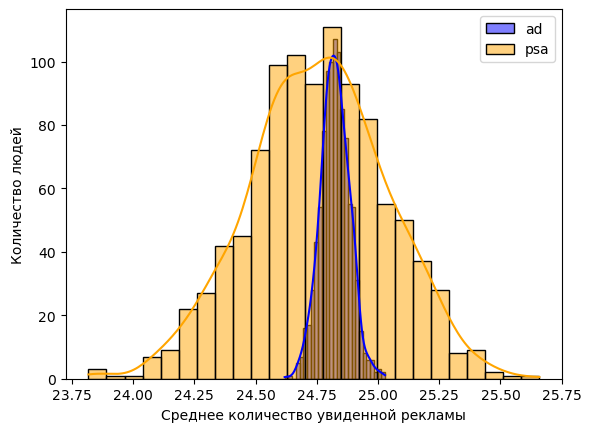

In [40]:
# Метод 2 - перепроверка
from sklearn.utils import resample


x_a = df_a['total ads']
# configure bootstrap
n_iterations = 1000
n_size = int(len(x_a))

# run bootstrap
mean_a = list()
for i in range(n_iterations):
    # prepare train and test sets
    s = resample(x_a, n_samples=n_size);
    m = np.mean(s);
    #print(m)
    mean_a.append(m)

# confidence intervals
alpha = 0.95
p_lower = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(mean_a, p_lower)

p_upper = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(mean_a, p_upper)
print('%.3f confidence interval %.3f and %.3f' % (alpha*100, lower, upper))


x_b = df_b['total ads']
# configure bootstrap
n_iterations = 1000
n_size = int(len(x_b))

# run bootstrap
mean_b = list()
for i in range(n_iterations):
    # prepare train and test sets
    s = resample(x_b, n_samples=n_size);
    m = np.mean(s);
    #print(m)
    mean_b.append(m)

# confidence intervals
alpha = 0.95
p_lower = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(mean_b, p_lower)

p_upper = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(mean_b, p_upper)
print('%.3f confidence interval %.3f and %.3f' % (alpha*100, lower, upper))

# Визуализация бутстрэп-распределений
sns.histplot(mean_a, kde=True, label='ad', color='Blue')
sns.histplot(mean_b, kde=True, label='psa', color ='Orange')
plt.xlabel('Среднее количество увиденной рекламы')
plt.ylabel('Количество людей')
plt.legend()
plt.show()



    Судя по данным доверительным интервалам, CI у разных групп пересекаются, что действительно заставляет задуматься, что разницы в среднем количестве просмотренной рекламмы у групп не имеется

        Выводы:
        1. Компании заинтересованы в ответах на два вопроса:

                1)Будет ли кампания успешной? - сложный вопрос, на который мы не получили ответ

                2)Если кампания была успешной, насколько этот успех можно объяснить рекламой? - статистическая значимость показывает, что разница в конверсиях в группах существует (конкретно для группы ad конверсия стат.значимо больше), однако ответить на вопрос об успехе благодаря рекламме сложно. На это есть причина: казалось бы стат.значимость говорит нам, что разница между средним количеством просмотренной рекламмы действительно существует (и вроде как тест Манна-Уитни greater говорит нам о том, что mean total ads в группе ad больше, хотя и незначительно), однако пересечение доверительных интервалов заставляет задуматься, что рекламма не сработала. 
